In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn import linear_model, ensemble
import warnings
warnings.filterwarnings("ignore")

# Загрузка данных
!wget https://www.dropbox.com/s/io67uppgq66plbp/training_data.csv
!wget https://www.dropbox.com/s/2ga9maqxbsf8xhg/test_data.csv
training_data = pd.read_csv('training_data.csv')

--2024-06-09 21:02:39--  https://www.dropbox.com/s/io67uppgq66plbp/training_data.csv
Распознаётся www.dropbox.com (www.dropbox.com)… 162.125.65.18, 2620:100:6021:18::a27d:4112
Подключение к www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 302 Found
Адрес: /scl/fi/0kvoo9vcdgou7blfzxwan/training_data.csv?rlkey=d3w2zbhlvbcz3h0zrq3zbht73 [переход]
--2024-06-09 21:02:44--  https://www.dropbox.com/scl/fi/0kvoo9vcdgou7blfzxwan/training_data.csv?rlkey=d3w2zbhlvbcz3h0zrq3zbht73
Повторное использование соединения с www.dropbox.com:443.
HTTP-запрос отправлен. Ожидание ответа… 302 Found
Адрес: https://uceea45b89a5ceeee9ddee8191d8.dl.dropboxusercontent.com/cd/0/inline/CUi5So63i52ZH7kylC2h3hvrvdo9nYxKsgS4V23RICaO7PDyQuayJA541rQn1jg4dXKcG5MpwvvGROQV46oKPj7LWmoPzAr-5vOdXBhnWS1hlqJmIJX9EevSHi7-AmOZc-gqrbUEdHRvYV5kftx18Yvm/file# [переход]
--2024-06-09 21:02:44--  https://uceea45b89a5ceeee9ddee8191d8.dl.dropboxusercontent.com/cd/0/inl

In [2]:
# Просмотр случайных записей
print(training_data.sample(10))

# Общая информация о данных
print(training_data.info())

# Общая статистика по данным
print(training_data.describe().T)

# Проверка общей информации о данных
print(training_data.info())

       SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
17486                 0                              0.094859   59   
863                   0                              0.423222   59   
36330                 0                              0.029286   53   
27164                 1                              0.032787   46   
4139                  0                              0.110380   43   
19868                 0                              1.564530   63   
6376                  0                              0.062897   71   
17714                 0                              0.995334   54   
11079                 0                              0.000000   56   
12688                 0                              0.145804   34   

       NumberOfTime30-59DaysPastDueNotWorse    DebtRatio  MonthlyIncome  \
17486                                     0     0.343628         5115.0   
863                                       0     0.253375         5406.0   
3633

In [3]:
# Рассчитываем средние значения
train_mean = training_data.mean()

# Заполняем пропуски
training_data.fillna(train_mean, inplace=True)
test_data = pd.read_csv('test_data.csv')
test_data.fillna(train_mean, inplace=True)

In [4]:
target_variable_name = 'SeriousDlqin2yrs'
training_values = training_data[target_variable_name]

# Отделяем входные переменные от выходной
training_points = training_data.drop(columns=[target_variable_name])

print(training_data.shape) # (50000, 11)
print(training_points.shape) # (50000, 10)

(50000, 11)
(50000, 10)


In [5]:
# Создаем модель логистической регрессии
logistic_regression_model = linear_model.LogisticRegression()
logistic_regression_model.fit(training_points, training_values)

# Создаем модель случайного леса
random_forest_model = ensemble.RandomForestClassifier()
random_forest_model.fit(training_points, training_values)

RandomForestClassifier()

In [6]:
# Загрузка тестовых данных
test_data = pd.read_csv('test_data.csv')
test_data.fillna(train_mean, inplace=True)

# Выделяем целевую переменную
test_values = test_data[target_variable_name]
test_points = test_data.drop(columns=[target_variable_name])

print(test_points.shape) # (37500, 10)

(37500, 10)


In [7]:
# Прогнозирование
test_predictions_logistic_regression = logistic_regression_model.predict(test_points)
test_predictions_random_forest = random_forest_model.predict(test_points)

# Оценка качества предсказаний
print(pd.Series(test_predictions_logistic_regression).value_counts())
print(pd.Series(test_predictions_random_forest).value_counts())

# Точность моделей
print("Точность логистической регрессии:", accuracy_score(test_values, test_predictions_logistic_regression))
print("Точность случайного леса:", accuracy_score(test_values, test_predictions_random_forest))

# Константный классификатор
constant_classifier_accuracy = accuracy_score(test_values, np.zeros_like(test_values))
print("Точность константного классификатора:", constant_classifier_accuracy)

0    37436
1       64
Name: count, dtype: int64
0    36655
1      845
Name: count, dtype: int64
Точность логистической регрессии: 0.9324533333333334
Точность случайного леса: 0.93376
Точность константного классификатора: 0.9326133333333333


In [8]:
# Матрица ошибок для логистической регрессии
logistic_regression_confusion_matrix = confusion_matrix(test_values, test_predictions_logistic_regression)
print(pd.DataFrame(logistic_regression_confusion_matrix))

# Матрица ошибок для случайного леса
random_forest_confusion_matrix = confusion_matrix(test_values, test_predictions_random_forest)
print(pd.DataFrame(random_forest_confusion_matrix))

# Альтернативный порог
test_probabilities = logistic_regression_model.predict_proba(test_points)[:, 1]
higher_threshold = 0.7
alternative_test_predictions = test_probabilities > higher_threshold
alternative_confusion_matrix = pd.DataFrame(confusion_matrix(test_values, alternative_test_predictions))
print(alternative_confusion_matrix)

# Порог 0.3
lower_threshold = 0.3
alternative_test_predictions_low = test_probabilities > lower_threshold
alternative_confusion_matrix_low = pd.DataFrame(confusion_matrix(test_values, alternative_test_predictions_low))
print(alternative_confusion_matrix_low)

       0   1
0  34938  35
1   2498  29
       0    1
0  34572  401
1   2083  444
       0   1
0  34947  26
1   2508  19
       0   1
0  34925  48
1   2483  44


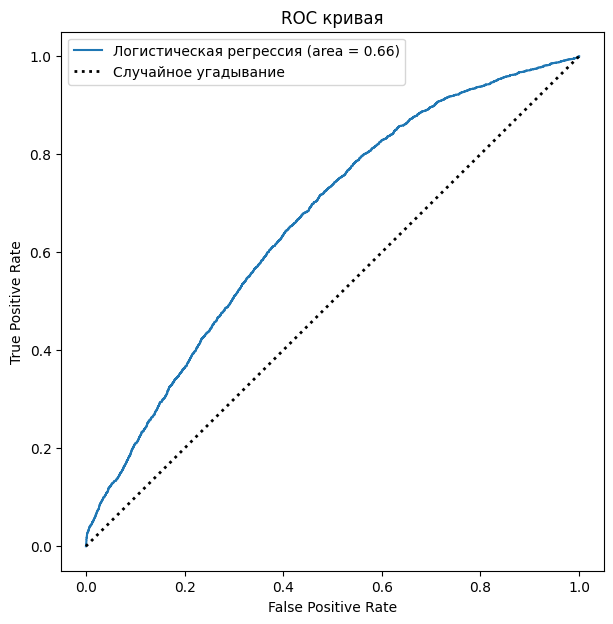

ROC-AUC для логистической регрессии: 0.6618060474284583


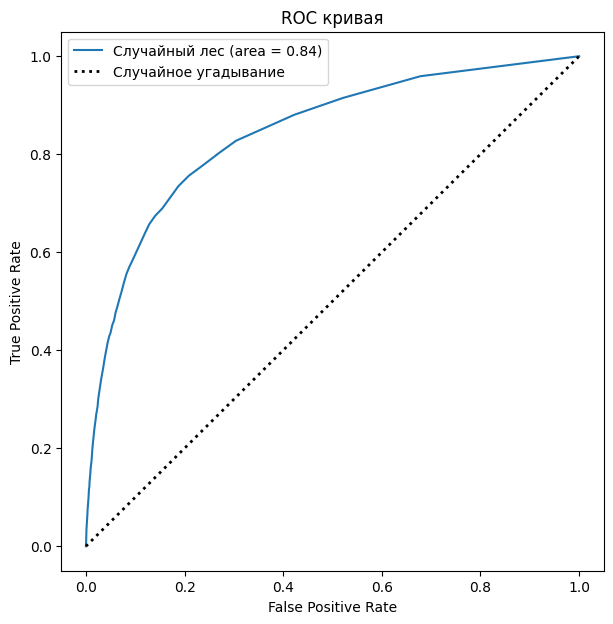

ROC-AUC для случайного леса: 0.8425000444969867


In [9]:
# ROC-AUC для логистической регрессии
test_probabilities = logistic_regression_model.predict_proba(test_points)[:, 1]
false_positive_rates, true_positive_rates, threshold = roc_curve(test_values, test_probabilities)
roc_auc_value = roc_auc_score(test_values, test_probabilities)

plt.figure(figsize=(7, 7))
plt.plot(false_positive_rates, true_positive_rates, label='Логистическая регрессия (area = %0.2f)' % roc_auc_value)
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', label='Случайное угадывание')
plt.title('ROC кривая')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

print("ROC-AUC для логистической регрессии:", roc_auc_value)

# ROC-AUC для случайного леса
test_probabilities_rf = random_forest_model.predict_proba(test_points)[:, 1]
false_positive_rates_rf, true_positive_rates_rf, threshold_rf = roc_curve(test_values, test_probabilities_rf)
roc_auc_value_rf = roc_auc_score(test_values, test_probabilities_rf)

plt.figure(figsize=(7, 7))
plt.plot(false_positive_rates_rf, true_positive_rates_rf, label='Случайный лес (area = %0.2f)' % roc_auc_value_rf)
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', label='Случайное угадывание')
plt.title('ROC кривая')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

print("ROC-AUC для случайного леса:", roc_auc_value_rf)